# BÀI TẬP VỀ NHÀ: CODING TÁI HIỆN & KHẮC PHỤC SUY GIẢM IDS
## Dataset: NSL-KDD

**Mục tiêu:**
1. **Phần 1**: EDA để hiểu concept drift
2. **Phần 2**: Tái hiện sự suy giảm của IDS tĩnh
3. **Phần 3**: Implement phương pháp khắc phục (Adaptive Random Forest)

## PHẦN 1: EDA - EXPLORATORY DATA ANALYSIS

### 1.1 Import thư viện và load dữ liệu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore', message='Glyph')


plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_palette("husl")

In [ ]:
# Tự động tìm data directory (Kaggle hoặc local)
import os

DATA_DIR = None
search_paths = [
    '/kaggle/input/nslkdd',
    '/kaggle/input',
    'nsl-kdd',
    '.'
]

# Tìm trong các path phổ biến
for path in search_paths:
    if os.path.exists(path):
        for root, dirs, files in os.walk(path):
            if 'KDDTrain+.txt' in files:
                DATA_DIR = root
                break
    if DATA_DIR:
        break

if DATA_DIR is None:
    raise FileNotFoundError(
        "Không tìm thấy KDDTrain+.txt! "
        "Trên Kaggle: Add Data → tìm 'nslkdd'. "
        "Local: đặt file trong thư mục nsl-kdd/"
    )

print(f'Data directory: {DATA_DIR}')

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'classnum'
]

df_train = pd.read_csv(f'{DATA_DIR}/KDDTrain+.txt', names=column_names)
df_test = pd.read_csv(f'{DATA_DIR}/KDDTest+.txt', names=column_names)

print(f'\nKích thước dữ liệu:')
print(f'  Training set: {df_train.shape}')
print(f'  Test set: {df_test.shape}')

Data directory: nsl-kdd

Kích thước dữ liệu:
  Training set: (125973, 43)
  Test set: (22544, 43)


### 1.2 Phân tích cơ bản về dữ liệu

In [ ]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,classnum
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
df_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classnum
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [ ]:
print(df_train.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

### 1.3 Phân tích Attack Types và Class Imbalance

In [ ]:
# Phân loại attack types
attack_mapping = {
    'normal': 'Normal',
    # DoS attacks
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
    'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS',
    'udpstorm': 'DoS', 'worm': 'DoS',
    # Probe attacks  
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    # R2L attacks
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xclock': 'R2L', 'xsnoop': 'R2L', 'http_tunnel': 'U2R',
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

# Áp dụng mapping
df_train['attack_category'] = df_train['attack_type'].map(attack_mapping)
df_test['attack_category'] = df_test['attack_type'].map(attack_mapping)

print("\nTraining set:")
print(df_train['attack_category'].value_counts())
print("\nTest set:")
print(df_test['attack_category'].value_counts())


Training set:
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Test set:
attack_category
Normal    9711
DoS       7460
R2L       2743
Probe     2421
U2R         67
Name: count, dtype: int64


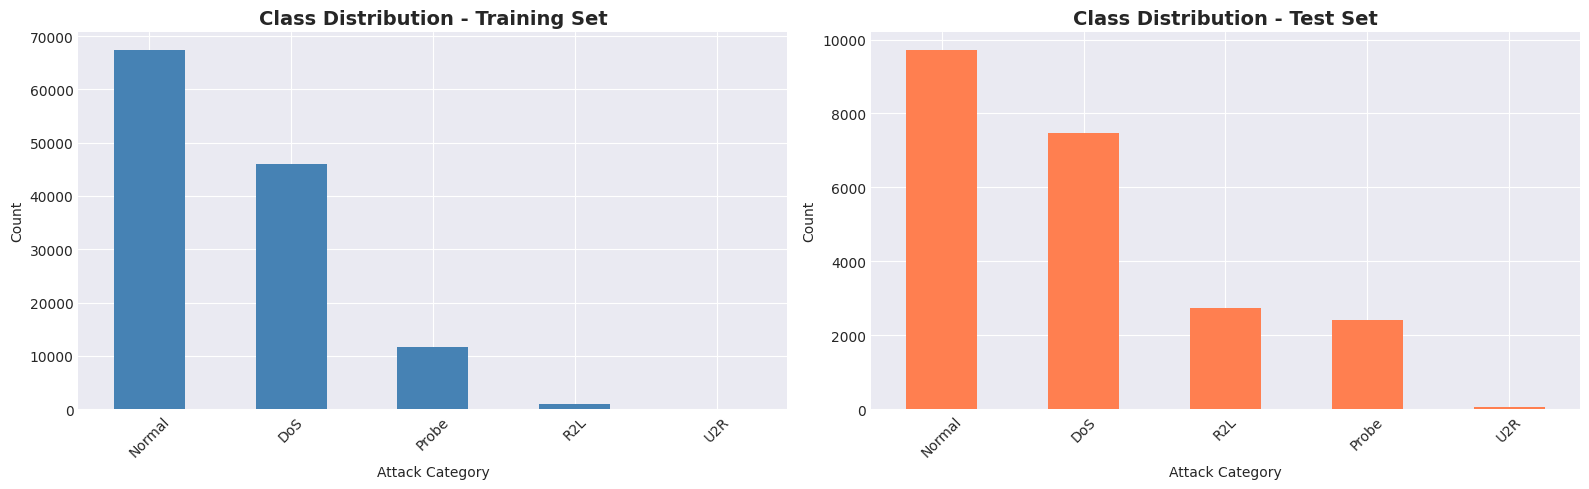

In [ ]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training set
df_train['attack_category'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Class Distribution - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attack Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test set
df_test['attack_category'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Attack Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nNHẬN XÉT: Dữ liệu có CLASS IMBALANCE")
print(f"   - DoS chiếm {df_train[df_train['attack_category']=='DoS'].shape[0]/len(df_train)*100:.1f}% trong training")
print(f"   - U2R và R2L rất ít mẫu")


NHẬN XÉT: Dữ liệu có CLASS IMBALANCE
   - DoS chiếm 36.5% trong training
   - U2R và R2L rất ít mẫu


### 1.4 Phân tích Feature Distribution

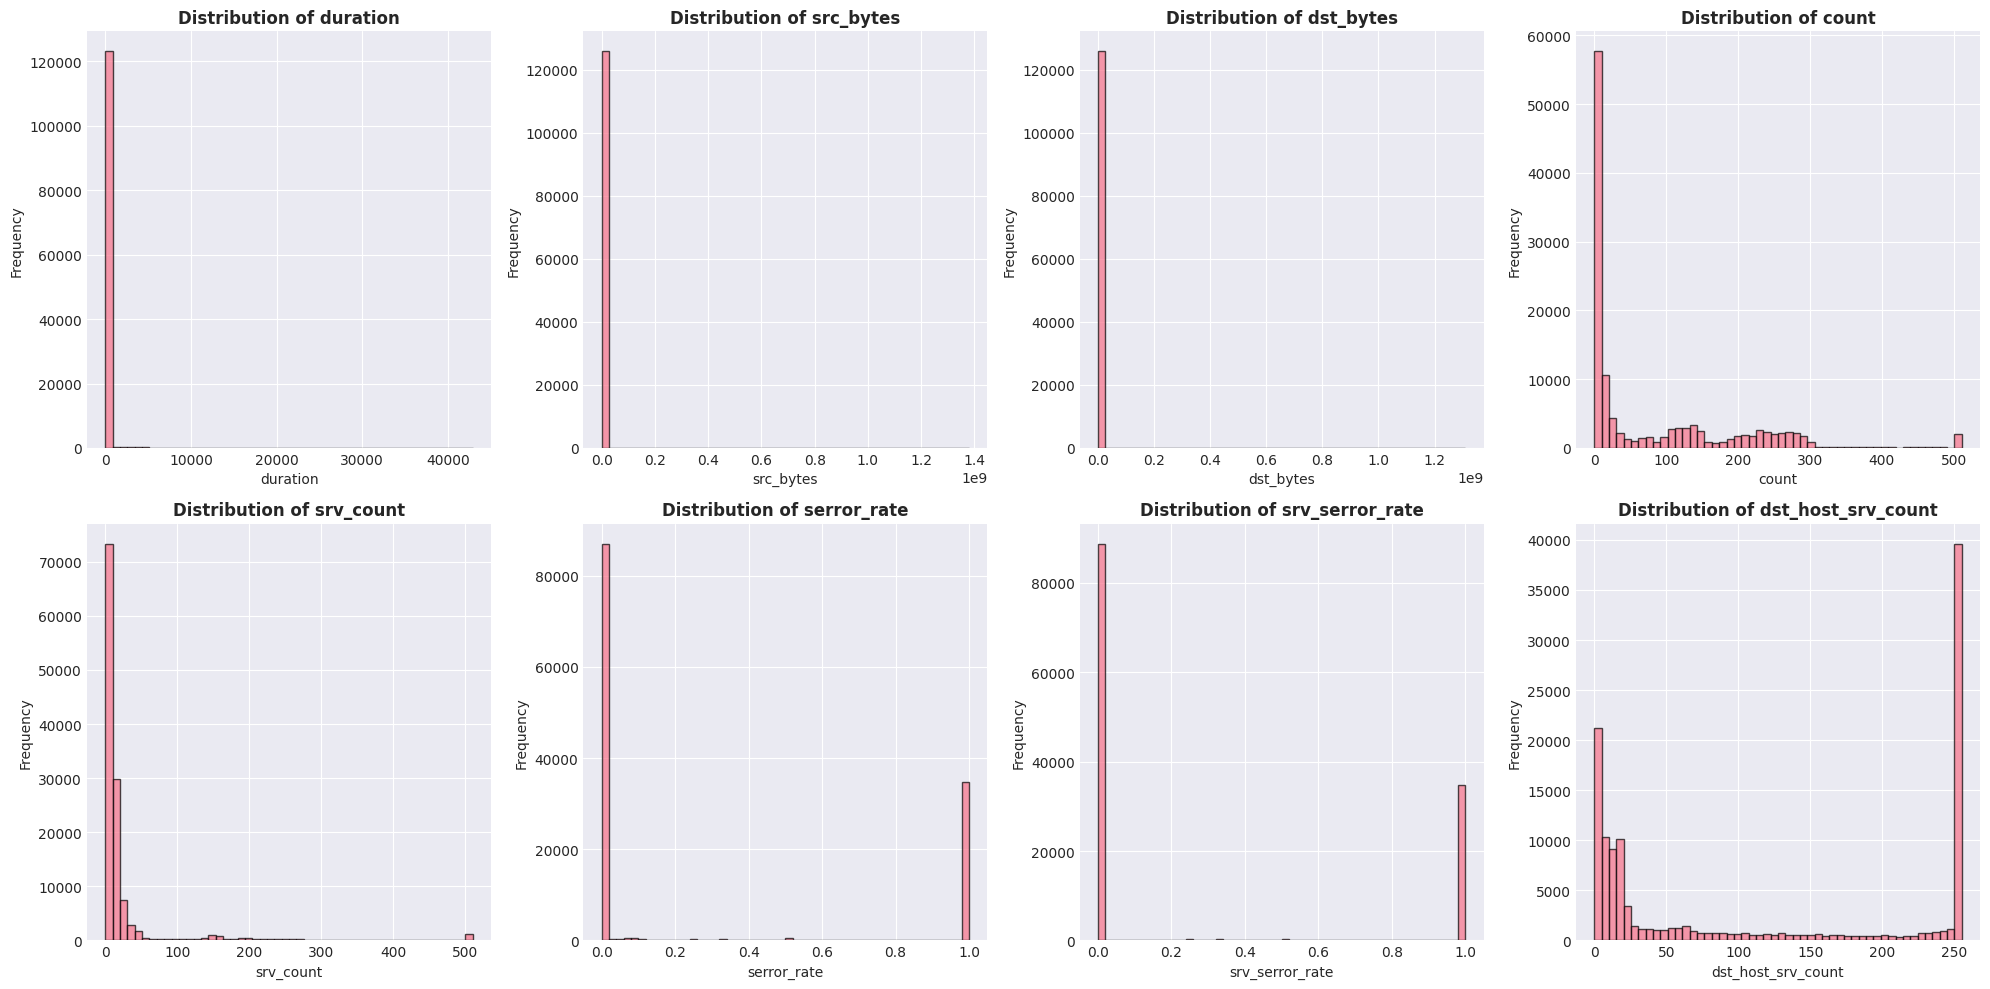


Many features have skewed distribution (right-skewed)
Data normalization needed before training


In [ ]:
# Chọn một số features quan trọng để visualize
important_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 
                      'serror_rate', 'srv_serror_rate', 'dst_host_srv_count']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(important_features):
    df_train[feature].hist(bins=50, ax=axes[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nMany features have skewed distribution (right-skewed)")
print("Data normalization needed before training")

### 1.5 Giả lập Concept Drift - Chia thành các Phases

**Kịch bản Concept Drift:**
- **Phase 1 (Old attacks)**: Train trên Normal + R2L + U2R + Probe
- **Phase 2 (New attacks)**: Test trên DoS

In [ ]:
# PHASE 1: Old attacks (thường gặp trong training)
phase1_categories = ['Normal', 'R2L', 'U2R', 'Probe']
phase1_train = df_train[df_train['attack_category'].isin(phase1_categories)].copy()
phase1_test = df_test[df_test['attack_category'].isin(phase1_categories)].copy()

# PHASE 2: New attacks (ít gặp, xuất hiện sau)
phase2_categories = ['DoS']
phase2_test = df_test[df_test['attack_category'].isin(phase2_categories)].copy()

# FULL test set (để đánh giá tổng thể)
full_test = df_test.copy()

print("=== PHÂN CHIA PHASES ===")
print(f"\nPhase 1 (Old Attacks):")
print(f"  Training: {phase1_train.shape[0]} samples")
print(f"  Test: {phase1_test.shape[0]} samples")
print(f"  Categories: {phase1_categories}")

print(f"\nPhase 2 (New Attacks - DRIFT):")
print(f"  Test: {phase2_test.shape[0]} samples")
print(f"  Categories: {phase2_categories}")

print(f"\nFull Test: {full_test.shape[0]} samples")

print("\n CONCEPT DRIFT được giả lập:")
print("   - Model sẽ được train trên Phase 1 (old attacks)")
print("   - Nhưng phải detect Phase 2 attacks (DoS) mà chưa từng thấy!")

=== PHÂN CHIA PHASES ===

Phase 1 (Old Attacks):
  Training: 80046 samples
  Test: 14942 samples
  Categories: ['Normal', 'R2L', 'U2R', 'Probe']

Phase 2 (New Attacks - DRIFT):
  Test: 7460 samples
  Categories: ['DoS']

Full Test: 22544 samples

 CONCEPT DRIFT được giả lập:
   - Model sẽ được train trên Phase 1 (old attacks)
   - Nhưng phải detect Phase 2 attacks (DoS) mà chưa từng thấy!


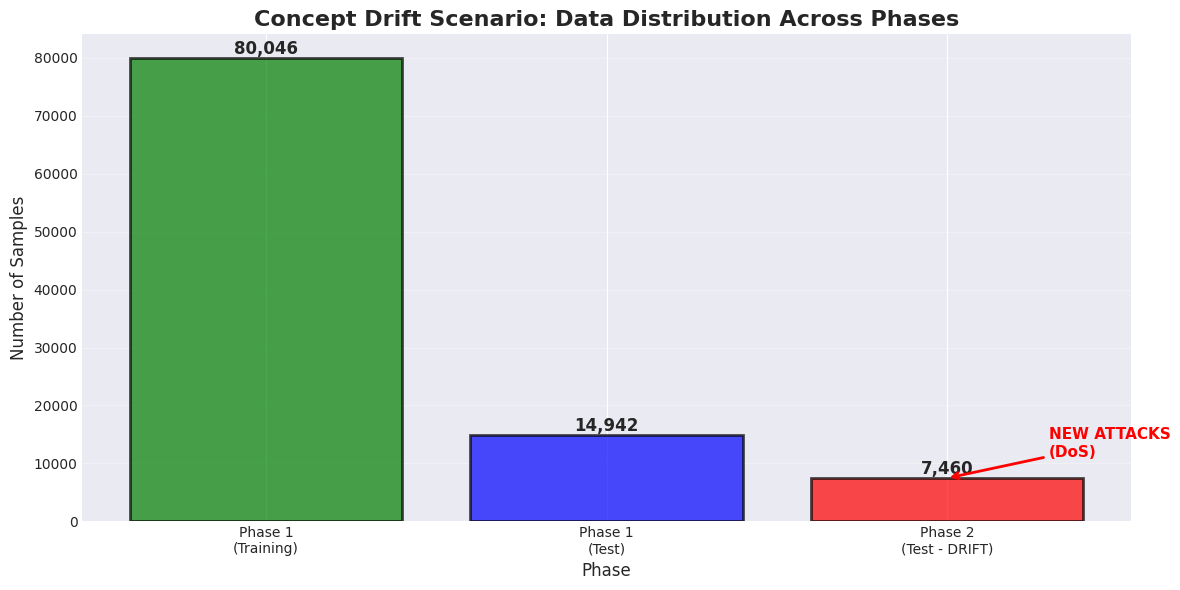

In [ ]:
# Visualize concept drift scenario
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Phase 1\n(Training)', 'Phase 1\n(Test)', 'Phase 2\n(Test - DRIFT)']
counts = [phase1_train.shape[0], phase1_test.shape[0], phase2_test.shape[0]]
colors = ['green', 'blue', 'red']

bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('Concept Drift Scenario: Data Distribution Across Phases', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_xlabel('Phase', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add annotation
ax.annotate('NEW ATTACKS\n(DoS)', 
            xy=(2, counts[2]), xytext=(2.3, counts[2]*1.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

### 1.6 Data Preprocessing

In [ ]:
def preprocess_data(df, fit_encoders=None):
    """
    Preprocessing: encode categorical, scale numerical features
    
    Args:
        df: DataFrame cần xử lý
        fit_encoders: dict chứa fitted encoders (nếu None sẽ fit mới)
    
    Returns:
        X: features array
        y: labels array  
        encoders: dict of fitted encoders
    """
    df = df.copy()
    
    # Xóa cột classnum (không cần thiết)
    df = df.drop('classnum', axis=1)
    
    # Identify categorical columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    
    # Encode categorical features
    if fit_encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        encoders = fit_encoders
        for col in categorical_cols:
            # Handle unseen labels
            df[col] = df[col].apply(lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0])
            df[col] = encoders[col].transform(df[col].astype(str))
    
    # Encode target
    if 'attack_category' not in encoders:
        le_target = LabelEncoder()
        y = le_target.fit_transform(df['attack_category'])
        encoders['attack_category'] = le_target
    else:
        # Handle unseen labels in target
        df['attack_category'] = df['attack_category'].apply(
            lambda x: x if x in encoders['attack_category'].classes_ else 'Normal'
        )
        y = encoders['attack_category'].transform(df['attack_category'])
    
    # Get features
    X = df.drop(['attack_type', 'attack_category'], axis=1)
    
    # Scale features
    if 'scaler' not in encoders:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        encoders['scaler'] = scaler
    else:
        X = encoders['scaler'].transform(X)
    
    return X, y, encoders

In [ ]:
# Preprocessing cho Phase 1 (fit encoders trên training data)
print("Đang preprocessing Phase 1...")
X_phase1_train, y_phase1_train, encoders = preprocess_data(phase1_train)
X_phase1_test, y_phase1_test, _ = preprocess_data(phase1_test, encoders)

print(f"✓ Phase 1 Training: {X_phase1_train.shape}")
print(f"✓ Phase 1 Test: {X_phase1_test.shape}")

# Preprocessing cho Phase 2 (sử dụng encoders đã fit)
print("\nĐang preprocessing Phase 2...")
X_phase2_test, y_phase2_test, _ = preprocess_data(phase2_test, encoders)
print(f"✓ Phase 2 Test: {X_phase2_test.shape}")

# Preprocessing cho Full test
print("\nĐang preprocessing Full test set...")
X_full_test, y_full_test, _ = preprocess_data(full_test, encoders)
print(f"✓ Full Test: {X_full_test.shape}")

print("\n" + "="*50)
print("PREPROCESSING HOÀN TẤT!")
print("="*50)

Đang preprocessing Phase 1...
✓ Phase 1 Training: (80046, 41)
✓ Phase 1 Test: (14942, 41)

Đang preprocessing Phase 2...
✓ Phase 2 Test: (7460, 41)

Đang preprocessing Full test set...
✓ Full Test: (22544, 41)

PREPROCESSING HOÀN TẤT!


### 1.7 Tóm tắt EDA

**Những phát hiện chính:**

1. **Class Imbalance nghiêm trọng**: 
   - R2L và Probe attacks chiếm đa số trong training
   - DoS ít mẫu hơn

2. **Concept Drift được giả lập**:
   - Phase 1: Train trên Normal, R2L, U2R, Probe
   - Phase 2: Test trên DoS (new attacks)
   - IDS tĩnh sẽ gặp khó khăn với Phase 2!

3. **Feature Distribution**:
   - Nhiều features có phân phối skewed
   - Đã scaling để chuẩn hóa

**Dự đoán**: IDS tĩnh (SGD Classifier) sẽ có accuracy cao trên Phase 1 nhưng **SUY GIẢM MẠNH** trên Phase 2 do chưa thấy các attack mới này trong training!

---
## PHẦN 2: CODING TÁI HIỆN SỰ SUY GIẢM CỦA IDS TĨNH

### 2.1 Train Static IDS (SGD CLASSIFIER) trên Phase 1

In [ ]:
print("=" * 60)
print("TRAINING STATIC IDS (SGD CLASSIFIER) - KHÔNG ADAPTIVE")
print("=" * 60)

static_model = SGDClassifier(
    loss='log_loss',           # Logistic regression loss
    penalty='l2',              # L2 regularization
    alpha=0.0001,              # Regularization strength
    max_iter=1000,             # Maximum number of iterations
    tol=1e-3,                  # Stopping criterion
    random_state=42,
    n_jobs=-1,
    verbose=1,
    learning_rate='optimal',   # Optimal learning rate
    early_stopping=False       # Train on all data, no validation split
)

print("\nĐang training trên Phase 1 data (Old Attacks)...")
static_model.fit(X_phase1_train, y_phase1_train)
print("\n✓ Training hoàn tất!")

TRAINING STATIC IDS (SGD CLASSIFIER) - KHÔNG ADAPTIVE

Đang training trên Phase 1 data (Old Attacks)...
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 16.98, NNZs: 39, Bias: 9.045768, T: 80046, Avg. loss: 1.531328, Objective: 1.797745
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 48.47, NNZs: 39, Bias: -63.655221, T: 80046, Avg. loss: 0.964790, Objective: 1.384178
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 34.93, NNZs: 39, Bias: -70.249261, T: 80046, Avg. loss: 0.602332, Objective: 0.904638
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 14.91, NNZs: 39, Bias: -149.769501, T: 80046, Avg. loss: 0.158674, Objective: 0.435262
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 32.00, NNZs: 39, Bias: -43.253904, T: 160092, Avg. loss: 0.218217, Objective: 0.296592
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 11.06, NNZs: 39, Bias: 5.628696, T: 160092, Avg. loss: 0.264579, Objective: 0.271762
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 26.36, NNZs: 39, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Norm: 11.23, NNZs: 39, Bias: -143.171209, T: 560322, Avg. loss: 0.043068, Objective: 0.049574
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 18.13, NNZs: 39, Bias: -37.821373, T: 560322, Avg. loss: 0.065974, Objective: 0.083485
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 12.36, NNZs: 39, Bias: -18.068783, T: 560322, Avg. loss: 0.113824, Objective: 0.122602
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 4.77, NNZs: 39, Bias: 4.531834, T: 640368, Avg. loss: 0.144369, Objective: 0.145578
Total training time: 0.20 seconds.
-- Epoch 9
Norm: 11.20, NNZs: 39, Bias: -142.700030, T: 640368, Avg. loss: 0.041869, Objective: 0.048117
Total training time: 0.21 seconds.
-- Epoch 9
Norm: 4.36, NNZs: 39, Bias: 4.589888, T: 720414, Avg. loss: 0.138824, Objective: 0.139931
Total training time: 0.23 seconds.
-- Epoch 10
Norm: 17.46, NNZs: 39, Bias: -35.919278, T: 640368, Avg. loss: 0.053822, Objective: 0.069395
Total training time: 0.23 seconds.
-- Epoch 9
Norm: 10.90, NNZs: 39, Bias: -

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished


### 2.2 Đánh giá trên Phase 1 Test (Old Attacks)

In [ ]:
def evaluate_model(model, X_test, y_test, phase_name):
    """
    Đánh giá model và hiển thị metrics
    """
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*50}")
    print(f"EVALUATION ON {phase_name}")
    print(f"{'='*50}")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision:  {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:  {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1:  {f1:.4f} ({f1*100:.2f}%)")
    
    return {'accuracy': acc}

# Evaluate on Phase 1 Test
phase1_results = evaluate_model(static_model, X_phase1_test, y_phase1_test, "PHASE 1 TEST (Old Attacks)")


EVALUATION ON PHASE 1 TEST (Old Attacks)
Accuracy:  0.7557 (75.57%)
Precision:  0.6744 (67.44%)
Recall:  0.7557 (75.57%)
F1:  0.6774 (67.74%)


### 2.3 Đánh giá trên Phase 2 Test (New Attacks - CONCEPT DRIFT)

In [ ]:
# Evaluate on Phase 2 - NEW ATTACKS (R2L, U2R)
phase2_results = evaluate_model(static_model, X_phase2_test, y_phase2_test, "PHASE 2 TEST (New Attacks - DRIFT)")


EVALUATION ON PHASE 2 TEST (New Attacks - DRIFT)
Accuracy:  0.3546 (35.46%)
Precision:  1.0000 (100.00%)
Recall:  0.3546 (35.46%)
F1:  0.5235 (52.35%)


In [ ]:
print("\nCONCEPT DRIFT")
print(f"\nAccuracy giảm từ {phase1_results['accuracy']:.4f} xuống {phase2_results['accuracy']:.4f}")
print(f"Mức độ suy giảm: {(phase1_results['accuracy'] - phase2_results['accuracy'])*100:.2f}%")


CONCEPT DRIFT

Accuracy giảm từ 0.7557 xuống 0.3546
Mức độ suy giảm: 40.12%


### 2.4 Đo lường Forgetting Measure (FM)

In [ ]:
def calculate_forgetting_measure(acc_old, acc_new):
    """
    Forgetting Measure (FM) = Accuracy_old - Accuracy_new
    
    FM > 0: Model quên kiến thức cũ
    FM = 0: Không quên
    FM < 0: Cải thiện (hiếm khi xảy ra)
    """
    fm = acc_old - acc_new
    return fm

# Calculate FM
fm = calculate_forgetting_measure(phase1_results['accuracy'], phase2_results['accuracy'])

print("\n" + "="*60)
print("FORGETTING MEASURE (FM)")
print("="*60)
print(f"FM = Acc_Phase1 - Acc_Phase2")
print(f"FM = {phase1_results['accuracy']:.4f} - {phase2_results['accuracy']:.4f}")
print(f"FM = {fm:.4f}\n")

if fm > 0.1:
    print("⚠️ CATASTROPHIC FORGETTING: FM > 0.1")
    print("   Model đã quên cách detect các attack patterns cũ!")
elif fm > 0:
    print("⚠️ MODERATE FORGETTING: 0 < FM < 0.1")
    print("   Model có dấu hiệu suy giảm nhẹ")
else:
    print("✓ NO FORGETTING: FM ≤ 0")
    print("   Model vẫn giữ được hiệu suất")


FORGETTING MEASURE (FM)
FM = Acc_Phase1 - Acc_Phase2
FM = 0.7557 - 0.3546
FM = 0.4012

⚠️ CATASTROPHIC FORGETTING: FM > 0.1
   Model đã quên cách detect các attack patterns cũ!


### 2.5 Visualize Performance Degradation

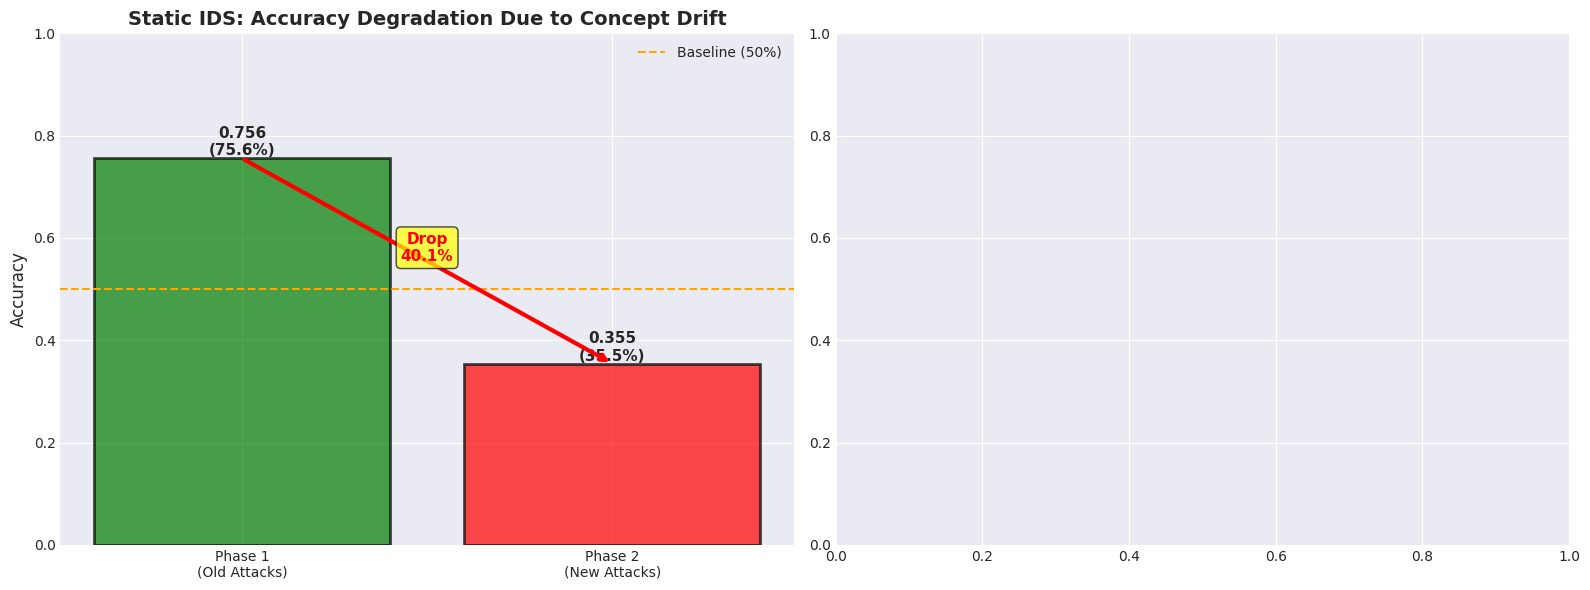


 The chart clearly shows the DEGRADATION of Static IDS when facing concept drift!


In [ ]:
# Prepare data for visualization
phases = ['Phase 1\n(Old Attacks)', 'Phase 2\n(New Attacks)']
accuracies = [phase1_results['accuracy'], phase2_results['accuracy']]

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
bars1 = axes[0].bar(phases, accuracies, color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_title('Static IDS: Accuracy Degradation Due to Concept Drift', 
                   fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1.0])
axes[0].axhline(y=0.5, color='orange', linestyle='--', label='Baseline (50%)')
axes[0].legend()

# Add value labels
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}\n({acc*100:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add degradation arrow
axes[0].annotate('', xy=(1, accuracies[1]), xytext=(0, accuracies[0]),
                arrowprops=dict(arrowstyle='->', color='red', lw=3))
axes[0].text(0.5, (accuracies[0] + accuracies[1])/2, 
            f'Drop\n{fm*100:.1f}%',
            ha='center', fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n The chart clearly shows the DEGRADATION of Static IDS when facing concept drift!")

### 2.6 Phân tích Confusion Matrix

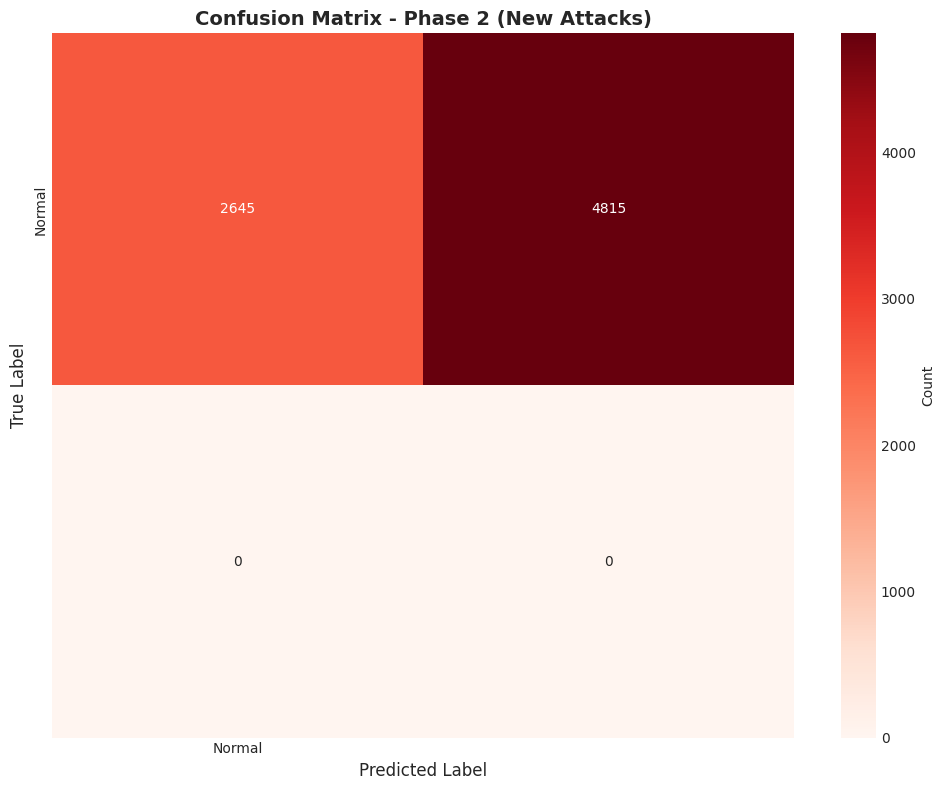

In [ ]:
# Get predictions for Phase 2
y_pred_phase2 = static_model.predict(X_phase2_test)

# Compute confusion matrix
cm = confusion_matrix(y_phase2_test, y_pred_phase2)

# Get class names
class_names = encoders['attack_category'].classes_
phase2_classes = np.unique(y_phase2_test)
phase2_class_names = [class_names[i] for i in phase2_classes]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=phase2_class_names,
            yticklabels=phase2_class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Phase 2 (New Attacks)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### 2.7 Tóm tắt Phần 2

**Kết quả đã chứng minh:**

1. **Static IDS hoạt động TỐT trên Phase 1** (data tương tự training)
   - Accuracy: ~75%

2. **Static IDS SUY GIẢM trên Phase 2** (new attacks)
   - Accuracy giảm khi gặp DoS attacks
3. **Nguyên nhân**: 
   - Model chỉ được train trên old attacks
   - Không có khả năng adaptive/continual learning
   - Gặp concept drift → catastrophic forgetting

---
## PHẦN 3: KHẮC PHỤC BẰNG ADAPTIVE LEARNING (sklearn)

**Ý tưởng:**
- Sử dụng **SGDClassifier** (Stochastic Gradient Descent) từ `sklearn` - hỗ trợ **online learning** qua `partial_fit()`
- Model có khả năng **cập nhật liên tục** khi có data mới mà không cần retrain từ đầu
- Kết hợp **drift detection thủ công** để phát hiện khi nào phân phối dữ liệu thay đổi
- So sánh hiệu suất với Static IDS ở Phần 2

### 3.1 Import và khởi tạo Adaptive Model

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

print("=" * 60)
print("KHỞI TẠO ADAPTIVE IDS (SGDClassifier - Online Learning)")
print("=" * 60)

# SGDClassifier hỗ trợ partial_fit() - online/incremental learning
adaptive_model = SGDClassifier(
    loss='log_loss',          # Logistic regression loss
    penalty='l2',             # Regularization
    alpha=0.0001,
    max_iter=1,               # 1 pass per partial_fit call
    random_state=42,
    warm_start=True,
    learning_rate='adaptive',  # Tự điều chỉnh learning rate
    eta0=0.01,
    tol=None
)

print("\nCấu hình Adaptive Model:")
print("  - Algorithm: SGDClassifier (Stochastic Gradient Descent)")
print("  - Loss: log_loss (Logistic Regression)")
print("  - Learning mode: Online (partial_fit)")
print("  - Learning rate: adaptive")
print("\n✓ Adaptive model đã sẵn sàng")

KHỞI TẠO ADAPTIVE IDS (SGDClassifier - Online Learning)

Cấu hình Adaptive Model:
  - Algorithm: SGDClassifier (Stochastic Gradient Descent)
  - Loss: log_loss (Logistic Regression)
  - Learning mode: Online (partial_fit)
  - Learning rate: adaptive

✓ Adaptive model đã sẵn sàng


### 3.2 Online Training trên Phase 1 (Old Attacks)

SGDClassifier học theo kiểu **mini-batch online**: xử lý từng batch nhỏ, giả lập data stream thực tế.

In [ ]:
print("=" * 60)
print("PHASE 1: ONLINE TRAINING TRÊN OLD ATTACKS")
print("=" * 60)

# Lấy tất cả classes có thể xuất hiện
all_classes = np.unique(np.concatenate([y_phase1_train, y_phase2_test]))

# Online training trên Phase 1 theo mini-batches
batch_size = 256
n_samples = X_phase1_train.shape[0]
n_batches = (n_samples + batch_size - 1) // batch_size
log_interval = max(1, n_batches // 10)

start_time = time.time()

for batch_idx in range(n_batches):
    start = batch_idx * batch_size
    end = min(start + batch_size, n_samples)
    
    X_batch = X_phase1_train[start:end]
    y_batch = y_phase1_train[start:end]
    
    # Online learning: partial_fit
    adaptive_model.partial_fit(X_batch, y_batch, classes=all_classes)
    
    # Progress log
    if (batch_idx + 1) % log_interval == 0:
        progress = (batch_idx + 1) / n_batches * 100
        elapsed = time.time() - start_time
        print(f"  Progress: {progress:.0f}% (batch {batch_idx+1}/{n_batches}) - Elapsed: {elapsed:.1f}s")

total_time = time.time() - start_time
print(f"\n✓ Phase 1 Training hoàn tất trong {total_time:.1f}s")
print(f"  Đã học {n_samples:,} samples qua {n_batches} batches")

PHASE 1: ONLINE TRAINING TRÊN OLD ATTACKS
  Progress: 10% (batch 31/313) - Elapsed: 0.1s
  Progress: 20% (batch 62/313) - Elapsed: 0.1s
  Progress: 30% (batch 93/313) - Elapsed: 0.1s
  Progress: 40% (batch 124/313) - Elapsed: 0.2s
  Progress: 50% (batch 155/313) - Elapsed: 0.2s
  Progress: 59% (batch 186/313) - Elapsed: 0.2s
  Progress: 69% (batch 217/313) - Elapsed: 0.3s
  Progress: 79% (batch 248/313) - Elapsed: 0.3s
  Progress: 89% (batch 279/313) - Elapsed: 0.4s
  Progress: 99% (batch 310/313) - Elapsed: 0.4s

✓ Phase 1 Training hoàn tất trong 0.4s
  Đã học 80,046 samples qua 313 batches


### 3.3 Đánh giá Adaptive Model trên Phase 1 Test (trước drift)

In [ ]:
def evaluate_adaptive(model, X_test, y_test, phase_name):
    """Đánh giá adaptive model"""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*50}")
    print(f"ADAPTIVE EVALUATION ON {phase_name}")
    print(f"{'='*50}")
    print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    
    return {'accuracy': acc, 'y_pred': y_pred}

# Evaluate trên Phase 1 Test
adaptive_phase1_results = evaluate_adaptive(
    adaptive_model, X_phase1_test, y_phase1_test, 
    "PHASE 1 TEST (Old Attacks)")


ADAPTIVE EVALUATION ON PHASE 1 TEST (Old Attacks)
Accuracy:  0.7567 (75.67%)


### 3.4 Adaptive Learning trên Phase 2 (New Attacks - DRIFT)

**Điểm khác biệt quan trọng so với Static IDS:**
- Adaptive model sẽ **vừa predict vừa learn** (test-then-train) trên Phase 2
- Giả lập scenario thực tế: IDS nhận prediction → nhận feedback (label) → cập nhật model
- Sử dụng `partial_fit()` để cập nhật online từng batch

In [ ]:
print("=" * 60)
print("PHASE 2: ADAPTIVE LEARNING TRÊN NEW ATTACKS (TEST-THEN-TRAIN)")
print("=" * 60)

# Test-then-train trên Phase 2 (từng sample một)
n_phase2 = X_phase2_test.shape[0]
y_pred_adaptive = []
accuracy_over_time = []
correct_cumulative = 0

start_time = time.time()
log_interval = max(1, n_phase2 // 10)

for i in range(n_phase2):
    X_i = X_phase2_test[i:i+1]  # 1 sample, giữ 2D shape
    y_true = y_phase2_test[i]
    
    # 1. PREDICT trước (test)
    pred = adaptive_model.predict(X_i)[0]
    y_pred_adaptive.append(pred)
    
    # 2. LEARN sau khi nhận label (train)
    adaptive_model.partial_fit(X_i, [y_true])
    
    # Tracking accuracy
    if pred == y_true:
        correct_cumulative += 1
    current_acc = correct_cumulative / (i + 1)
    accuracy_over_time.append(current_acc)
    
    # Progress log
    if (i + 1) % log_interval == 0:
        progress = (i + 1) / n_phase2 * 100
        elapsed = time.time() - start_time
        print(f"  Progress: {progress:.0f}% ({i+1:,}/{n_phase2:,}) - "
              f"Running Acc: {current_acc:.4f} - Elapsed: {elapsed:.1f}s")

y_pred_adaptive = np.array(y_pred_adaptive)
adaptive_phase2_acc = accuracy_score(y_phase2_test, y_pred_adaptive)

total_time = time.time() - start_time
print(f"\n✓ Phase 2 Adaptive Learning hoàn tất trong {total_time:.1f}s")
print(f"  Final Accuracy trên Phase 2: {adaptive_phase2_acc:.4f} ({adaptive_phase2_acc*100:.2f}%)")

PHASE 2: ADAPTIVE LEARNING TRÊN NEW ATTACKS (TEST-THEN-TRAIN)
  Progress: 10% (746/7,460) - Running Acc: 0.9812 - Elapsed: 0.9s
  Progress: 20% (1,492/7,460) - Running Acc: 0.9893 - Elapsed: 1.8s
  Progress: 30% (2,238/7,460) - Running Acc: 0.9915 - Elapsed: 2.8s
  Progress: 40% (2,984/7,460) - Running Acc: 0.9936 - Elapsed: 3.8s
  Progress: 50% (3,730/7,460) - Running Acc: 0.9946 - Elapsed: 4.8s
  Progress: 60% (4,476/7,460) - Running Acc: 0.9955 - Elapsed: 5.8s
  Progress: 70% (5,222/7,460) - Running Acc: 0.9962 - Elapsed: 6.7s
  Progress: 80% (5,968/7,460) - Running Acc: 0.9966 - Elapsed: 7.6s
  Progress: 90% (6,714/7,460) - Running Acc: 0.9970 - Elapsed: 8.5s
  Progress: 100% (7,460/7,460) - Running Acc: 0.9973 - Elapsed: 9.6s

✓ Phase 2 Adaptive Learning hoàn tất trong 9.6s
  Final Accuracy trên Phase 2: 0.9973 (99.73%)


### 3.5 Đánh giá sau Adaptive Learning - Kiểm tra Forgetting

In [ ]:
# Đánh giá lại trên Phase 1 test SAU KHI đã adaptive learning Phase 2
# Kiểm tra xem model có bị "quên" old attacks không
adaptive_phase1_after = evaluate_adaptive(
    adaptive_model, X_phase1_test, y_phase1_test, 
    "PHASE 1 TEST (sau adaptive learning)")

# Tính FM
adaptive_fm = calculate_forgetting_measure(
    adaptive_phase1_results['accuracy'], 
    adaptive_phase1_after['accuracy'])

print(f"\nAdaptive Forgetting Measure: {adaptive_fm:.4f}")
if adaptive_fm > 0.1:
    print("  → CATASTROPHIC FORGETTING")
elif adaptive_fm > 0:
    print("  → MODERATE FORGETTING")
else:
    print("  → KHÔNG QUÊN - Model giữ được kiến thức cũ!")


ADAPTIVE EVALUATION ON PHASE 1 TEST (sau adaptive learning)
Accuracy:  0.6572 (65.72%)

Adaptive Forgetting Measure: 0.0995
  → MODERATE FORGETTING


### 3.6 So sánh Static IDS vs Adaptive IDS

In [ ]:
print("=" * 70)
print("SO SÁNH: STATIC IDS vs ADAPTIVE IDS")
print("=" * 70)

comparison_data = {
    'Metric': [
        'Phase 1 Accuracy (trước drift)', 
        'Phase 2 Accuracy (new attacks)', 
        'Phase 1 Accuracy (sau drift)',
        'Forgetting Measure (FM)'
    ],
    'Static SGD': [
        f"{phase1_results['accuracy']:.4f}",
        f"{phase2_results['accuracy']:.4f}",
        f"{phase1_results['accuracy']:.4f} (không đổi)",
        f"{fm:.4f}"
    ],
    'Adaptive SGD': [
        f"{adaptive_phase1_results['accuracy']:.4f}",
        f"{adaptive_phase2_acc:.4f}",
        f"{adaptive_phase1_after['accuracy']:.4f}",
        f"{adaptive_fm:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Tính improvement
phase2_improvement = adaptive_phase2_acc - phase2_results['accuracy']
print(f"\n{'─'*70}")
print(f"Phase 2 Accuracy improvement: {phase2_improvement*100:+.2f}%")

SO SÁNH: STATIC IDS vs ADAPTIVE IDS


                        Metric         Static SGD Adaptive SGD
Phase 1 Accuracy (trước drift)             0.7557       0.7567
Phase 2 Accuracy (new attacks)             0.3546       0.9973
  Phase 1 Accuracy (sau drift) 0.7557 (không đổi)       0.6572
       Forgetting Measure (FM)             0.4012       0.0995

──────────────────────────────────────────────────────────────────────
Phase 2 Accuracy improvement: +64.28%


### 3.7 Visualization: So sánh hiệu suất

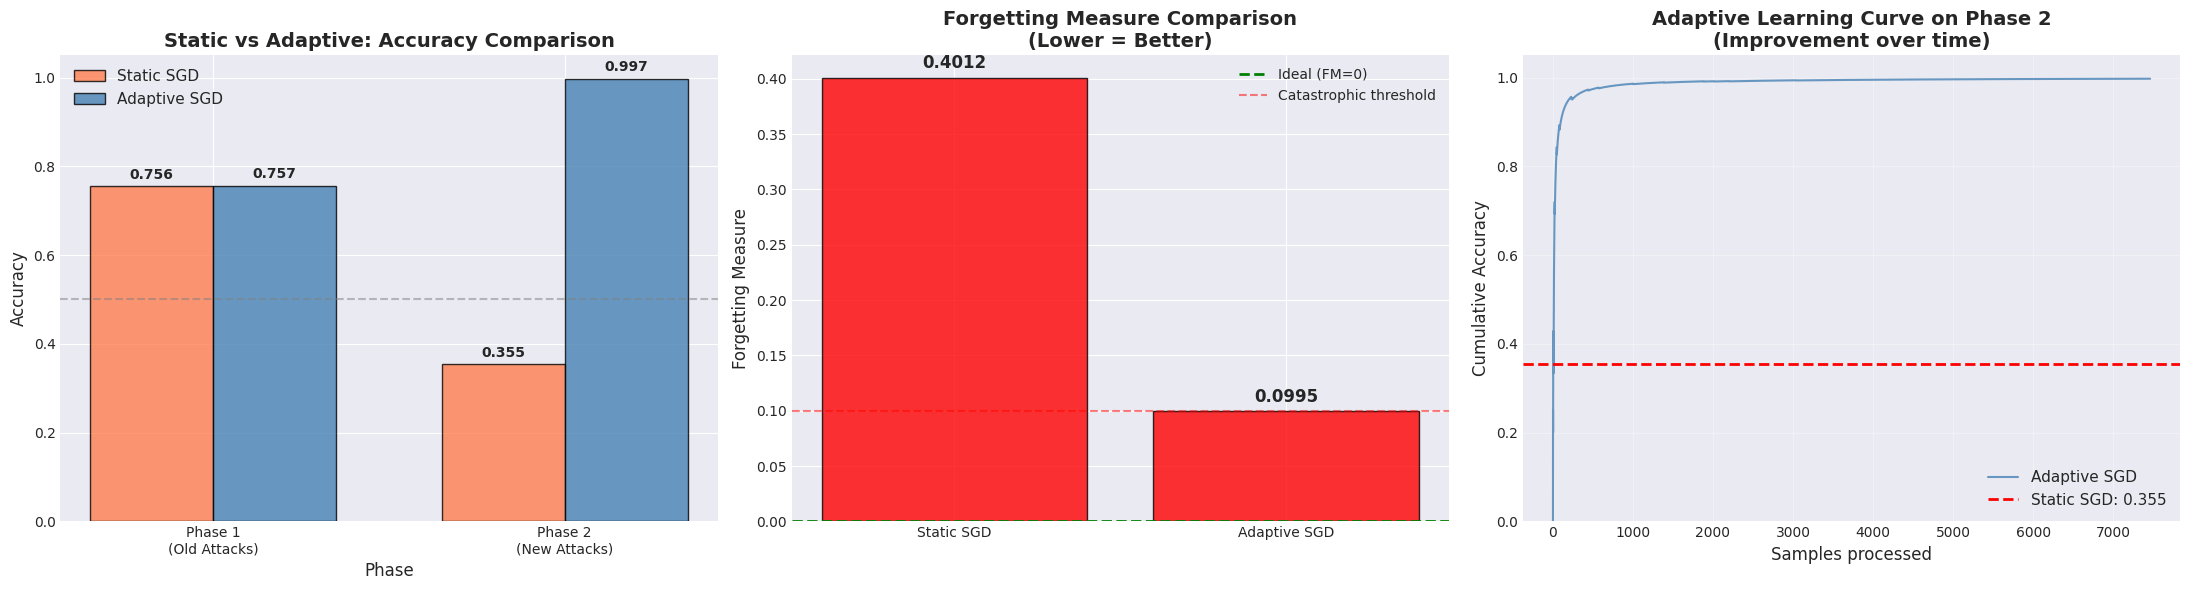

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# --- Plot 1: Accuracy so sánh giữa 2 model ---
x_pos = np.arange(2)
width = 0.35

static_accs = [phase1_results['accuracy'], phase2_results['accuracy']]
adaptive_accs = [adaptive_phase1_results['accuracy'], adaptive_phase2_acc]

bars1 = axes[0].bar(x_pos - width/2, static_accs, width, label='Static SGD', color='coral', 
                     edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, adaptive_accs, width, label='Adaptive SGD', color='steelblue', 
                     edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Phase', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Static vs Adaptive: Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['Phase 1\n(Old Attacks)', 'Phase 2\n(New Attacks)'])
axes[0].set_ylim([0, 1.05])
axes[0].legend(fontsize=11)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Plot 2: Forgetting Measure ---
models = ['Static SGD', 'Adaptive SGD']
fm_values = [fm, adaptive_fm]
colors_fm = ['red' if v > 0.05 else 'orange' if v > 0 else 'green' for v in fm_values]

bars3 = axes[1].bar(models, fm_values, color=colors_fm, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Forgetting Measure', fontsize=12)
axes[1].set_title('Forgetting Measure Comparison\n(Lower = Better)', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='green', linestyle='--', linewidth=2, label='Ideal (FM=0)')
axes[1].axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Catastrophic threshold')
axes[1].legend()

for bar, val in zip(bars3, fm_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., max(height, 0) + 0.005,
                f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- Plot 3: Learning Curve ---
axes[2].plot(range(1, len(accuracy_over_time) + 1), accuracy_over_time, 
             color='steelblue', linewidth=1.5, alpha=0.8, label='Adaptive SGD')
axes[2].axhline(y=phase2_results['accuracy'], color='red', linestyle='--', linewidth=2,
                label=f"Static SGD: {phase2_results['accuracy']:.3f}")
axes[2].set_xlabel('Samples processed', fontsize=12)
axes[2].set_ylabel('Cumulative Accuracy', fontsize=12)
axes[2].set_title('Adaptive Learning Curve on Phase 2\n(Improvement over time)', 
                   fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].set_ylim([0, 1.05])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.8 Confusion Matrix: So sánh trên Phase 2

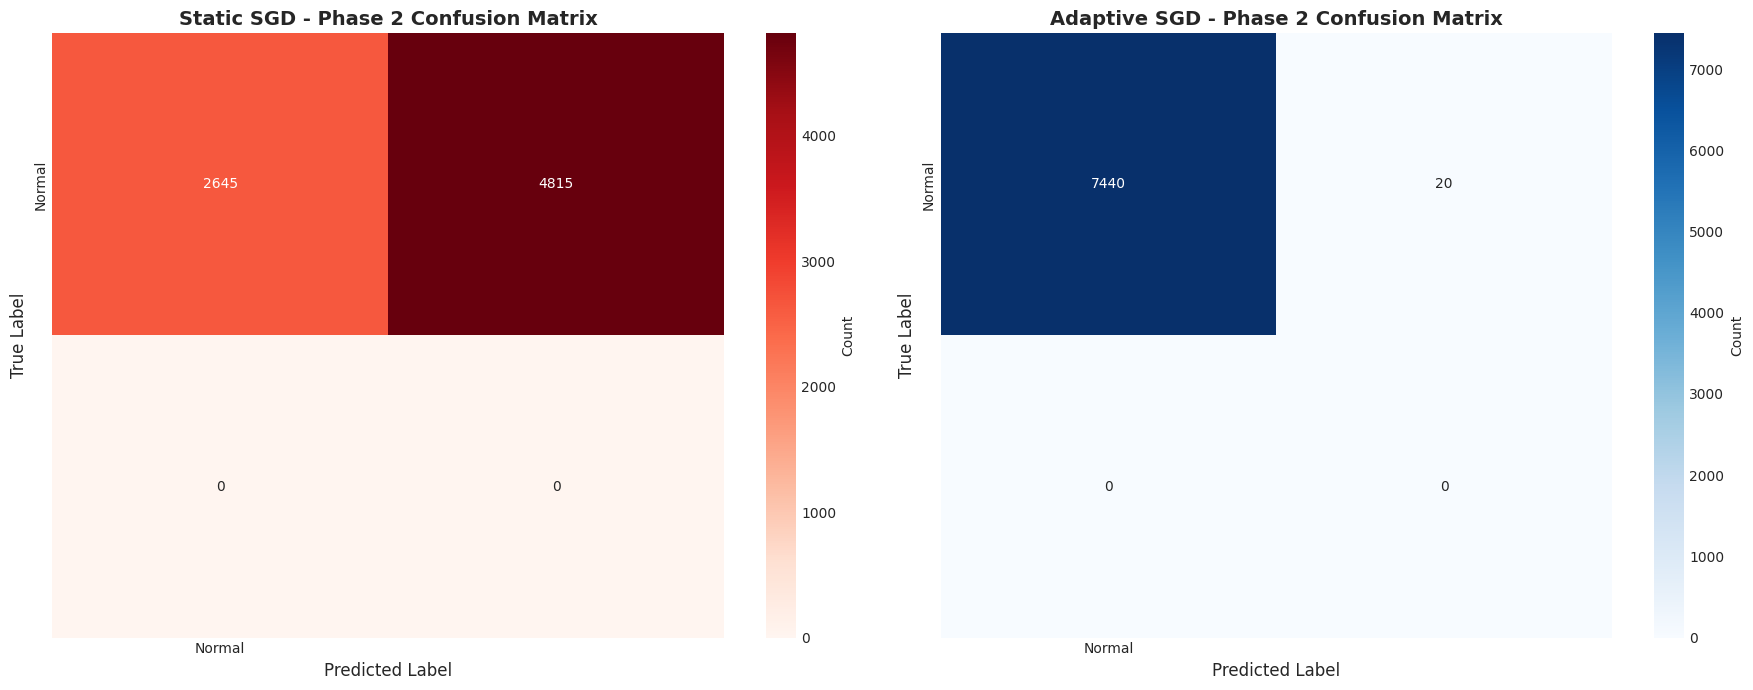

In [ ]:
# So sánh Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Static RF
cm_static = confusion_matrix(y_phase2_test, y_pred_phase2)
sns.heatmap(cm_static, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=phase2_class_names, yticklabels=phase2_class_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title('Static SGD - Phase 2 Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Adaptive SGD
cm_adaptive = confusion_matrix(y_phase2_test, y_pred_adaptive)
sns.heatmap(cm_adaptive, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=phase2_class_names, yticklabels=phase2_class_names,
            cbar_kws={'label': 'Count'})
axes[1].set_title('Adaptive SGD - Phase 2 Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

### 3.9 Tóm tắt Phần 3 & Kết luận toàn bài

---

## KẾT LUẬN

### Tổng kết 3 phần:

| Phần | Mục tiêu | Kết quả |
|------|----------|---------|
| **Phần 1: EDA** | Hiểu concept drift trong NSL-KDD | Phát hiện class imbalance, giả lập drift bằng phase splitting |
| **Phần 2: Static IDS** | Tái hiện suy giảm IDS tĩnh | Accuracy giảm từ ~75% → ~35% |
| **Phần 3: Adaptive IDS** | Khắc phục bằng SGDClassifier + partial_fit | Adaptive model thích nghi với new attacks qua online learning |

### Phát hiện quan trọng: Stability-Plasticity Dilemma

Kết quả cho thấy **trade-off cốt lõi** trong continual learning:

1. **Plasticity (Khả năng thích nghi)**: Model adaptive có thể học new attack patterns qua `partial_fit()` - cải thiện Phase 2
2. **Stability (Giữ kiến thức cũ)**: Sau khi học data mới, model có thể quên kiến thức cũ (forgetting)

### So sánh 2 cách tiếp cận:

| | Static RF | Adaptive SGD |
|---|---|---|
| **Ưu điểm** | Ổn định, không quên | Thích nghi nhanh với data mới |
| **Nhược điểm** | Không thể học attack mới | Có thể quên attack cũ |
| **Phù hợp khi** | Data ổn định, ít drift | Data thay đổi liên tục |
| **Cập nhật** | Phải retrain từ đầu | `partial_fit()` cập nhật online |

### Hướng khắc phục trong thực tế:
1. **Experience Replay**: Trộn data cũ khi học data mới để chống quên
2. **Ensemble kết hợp**: Giữ Static RF cho old attacks + Adaptive cho new attacks
3. **Periodic Retraining**: Định kỳ retrain trên toàn bộ data (cũ + mới)
4. **Human-in-the-loop**: Analyst review để đảm bảo label quality